# Image Segmentation - CamVid Segmentation

## Download dataset

In [4]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
! kaggle datasets download carlolepelaars/camvid

100% 573M/575M [00:29<00:00, 21.1MB/s]
100% 575M/575M [00:29<00:00, 20.6MB/s]


In [6]:
! unzip camvid.zip

Archive:  camvid.zip
  inflating: CamVid/class_dict.csv   
  inflating: CamVid/test/0001TP_006690.png  
  inflating: CamVid/test/0001TP_006720.png  
  inflating: CamVid/test/0001TP_006750.png  
  inflating: CamVid/test/0001TP_006780.png  
  inflating: CamVid/test/0001TP_006810.png  
  inflating: CamVid/test/0001TP_006840.png  
  inflating: CamVid/test/0001TP_006870.png  
  inflating: CamVid/test/0001TP_006900.png  
  inflating: CamVid/test/0001TP_006930.png  
  inflating: CamVid/test/0001TP_006960.png  
  inflating: CamVid/test/0001TP_006990.png  
  inflating: CamVid/test/0001TP_007020.png  
  inflating: CamVid/test/0001TP_007050.png  
  inflating: CamVid/test/0001TP_007080.png  
  inflating: CamVid/test/0001TP_007110.png  
  inflating: CamVid/test/0001TP_007140.png  
  inflating: CamVid/test/0001TP_007170.png  
  inflating: CamVid/test/0001TP_007200.png  
  inflating: CamVid/test/0001TP_007230.png  
  inflating: CamVid/test/0001TP_007260.png  
  inflating: CamVid/test/0001TP_007290.pn

## Importing Packages

In [7]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from tensorflow.keras.utils import load_img, img_to_array, plot_model

## Loading Dataset

In [21]:
# Paths
BATCH_SIZE = 16
IMAGE_SIZE = 128
TRAIN_PATH = "/content/CamVid/train"
VALID_PATH = "/content/CamVid/val"
TEST_PATH  = "/content/CamVid/test"

In [22]:
def load_image(path):
    image = load_img(path)
    image = img_to_array(image)
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = tf.cast(image, tf.float32)
    image = image/255.
    return image

def load_images(path_list):
    images = np.zeros(shape=(len(path_list), IMAGE_SIZE, IMAGE_SIZE, 3))
    for idx, path in tqdm(enumerate(path_list), desc="Loading"):
        image = load_image(path)
        images[idx] = image
    return images

def load_data(root_path):
    
    # Generate The Image paths
    image_paths = sorted(glob(root_path  + '/*.png'))
    label_map_paths = sorted(glob(root_path + '_labels/*.png'))

    # Load the Images
    images = load_images(image_paths)
    label_maps = load_images(label_map_paths)
    
    return images, label_maps

In [23]:
# Load Training Data
train_images, train_label_maps = load_data(TRAIN_PATH)

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_label_maps))
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

Loading: 369it [00:10, 33.58it/s]
Loading: 369it [00:04, 87.64it/s]


In [24]:
# Load Validation Data
valid_images, valid_label_maps = load_data(VALID_PATH)

valid_ds = tf.data.Dataset.from_tensor_slices((valid_images, valid_label_maps))
valid_ds = valid_ds.batch(BATCH_SIZE, drop_remainder=True)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

Loading: 100it [00:02, 34.18it/s]
Loading: 100it [00:01, 88.02it/s]


In [25]:
# Load Testing Data
test_images, test_label_maps = load_data(TEST_PATH)

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_label_maps))
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

Loading: 232it [00:06, 34.15it/s]
Loading: 232it [00:02, 89.13it/s]


## Visualizing data

In [26]:
def show_maps(data, n_images=10, model=None, SIZE=(20,10), ALPHA=0.5, explain=False):
    
    # plot Configurations
    if model is not None:
        n_cols = 4
    else:
        n_cols = 3
    
    # Select the Data
    images, label_maps = next(iter(data))
    
    if model is None:
        # Create N plots where N = Number of Images
        for image_no in range(n_images):

            # Figure Size
            plt.figure(figsize=SIZE)

            # Select Image and Label Map 
            id = np.random.randint(len(images))
            image, label_map = images[id], label_maps[id]

            # Plot Image 
            plt.subplot(1, n_cols, 1)
            plt.imshow(image)
            plt.title("Original Image")
            plt.axis('off')

            # Plot Label Map
            plt.subplot(1, n_cols, 2)
            plt.imshow(label_map)
            plt.title('Original Label Map')
            plt.axis('off')

            # Plot Mixed Overlap
            plt.subplot(1, n_cols, 3)
            plt.imshow(image)
            plt.imshow(label_map, alpha=ALPHA)
            plt.title("Overlap")
            plt.axis('off')

            # Final Show
            plt.show()

    else:
        # Create N plots where N = Number of Images
        for image_no in range(n_images):

            # Figure Size
            plt.figure(figsize=SIZE)

            # Select Image and Label Map 
            id = np.random.randint(len(images))
            image, label_map = images[id], label_maps[id]
            pred_map = model.predict(image[np.newaxis, ...])[0]

            # Plot Image 
            plt.subplot(1, n_cols, 1)
            plt.imshow(image)
            plt.title("Original Image")
            plt.axis('off')

            # Plot Original Label Map
            plt.subplot(1, n_cols, 2)
            plt.imshow(label_map)
            plt.title('Original Label Map')
            plt.axis('off')
            
            # Plot Predicted Label Map
            plt.subplot(1, n_cols, 3)
            plt.imshow(pred_map)
            plt.title('Predicted Label Map')
            plt.axis('off')
            
            # Plot Mixed Overlap
            plt.subplot(1, n_cols, 4)
            plt.imshow(image)
            plt.imshow(pred_map, alpha=ALPHA)
            plt.title("Overlap")
            plt.axis('off')

            # Final Show
            plt.show()

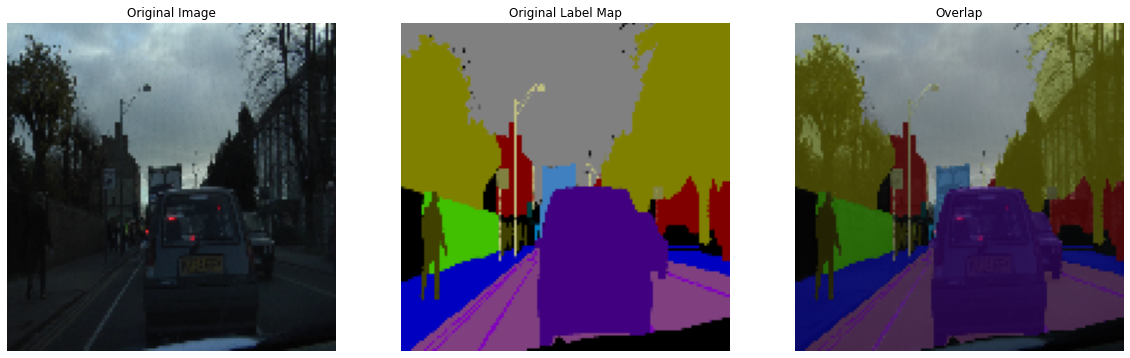

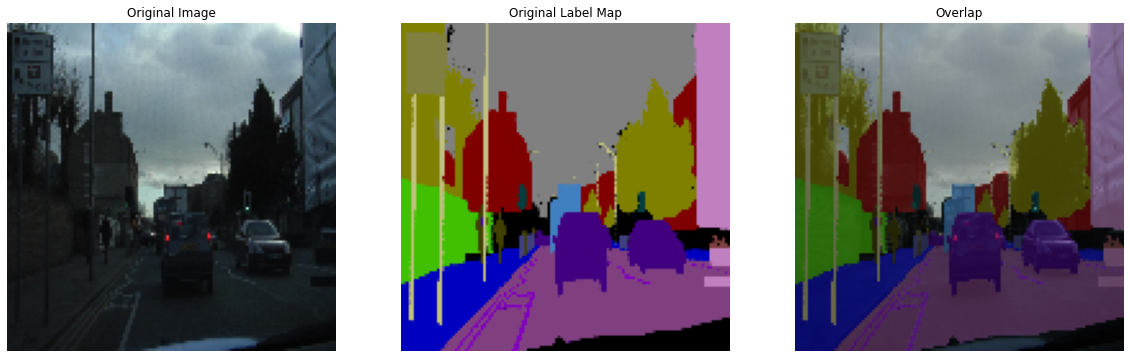

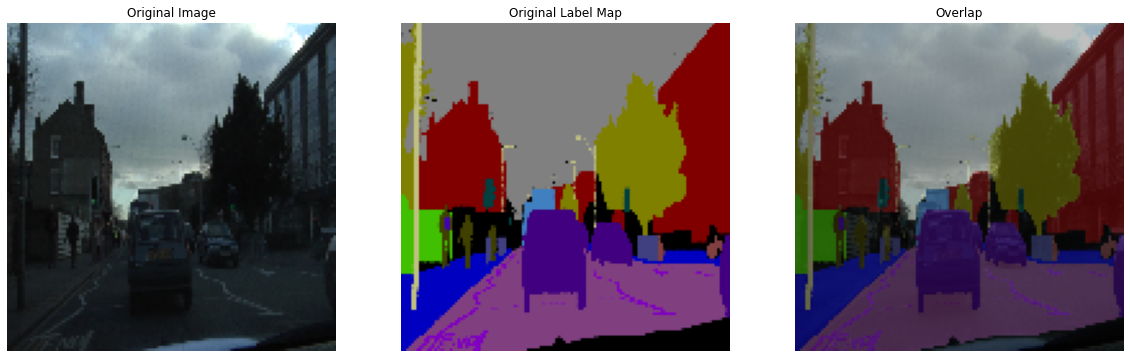

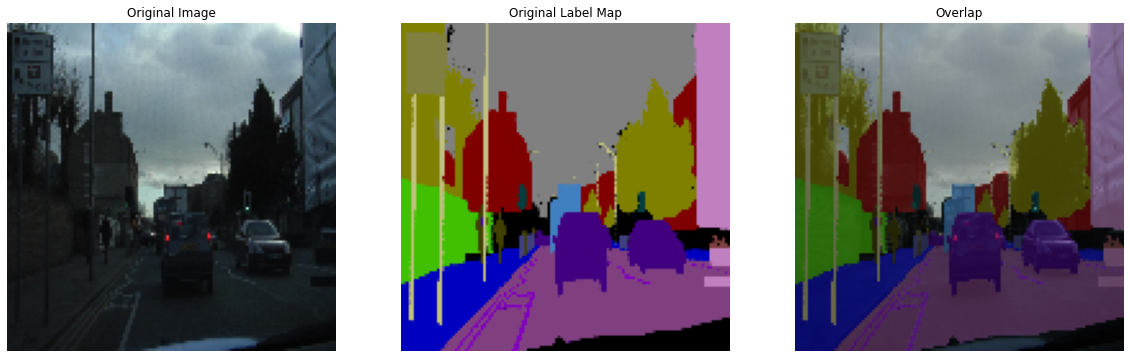

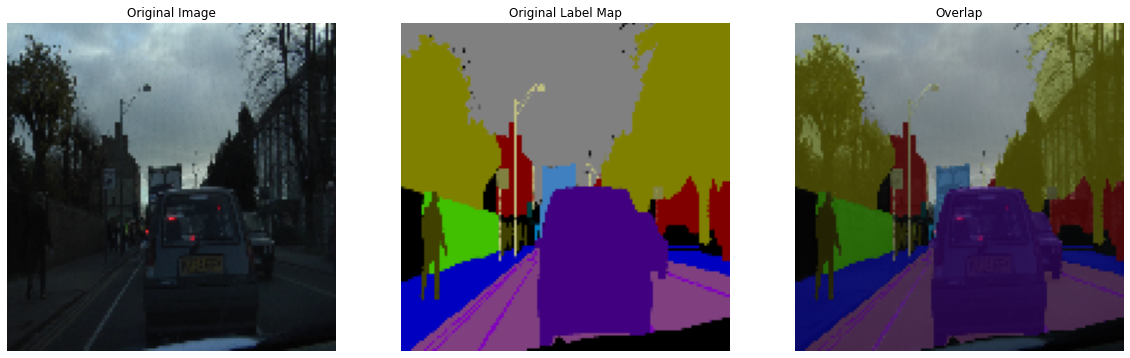

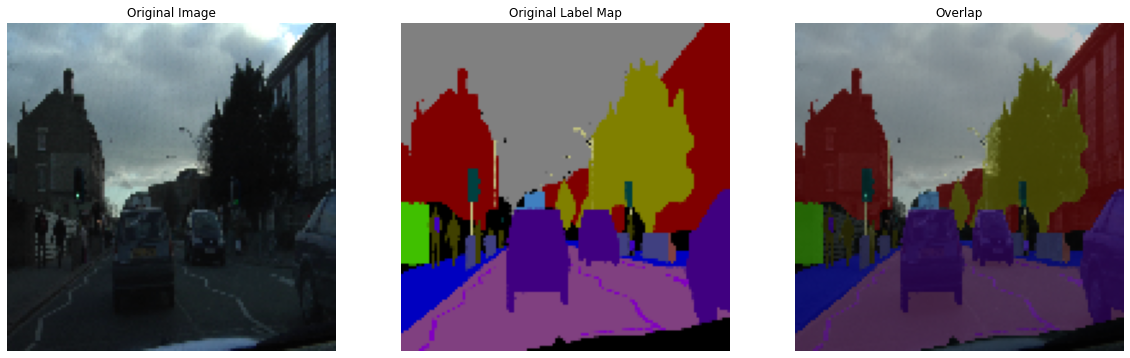

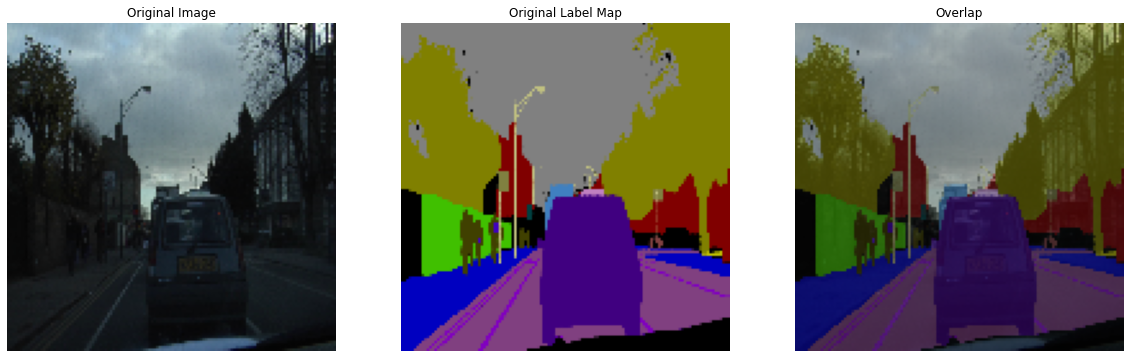

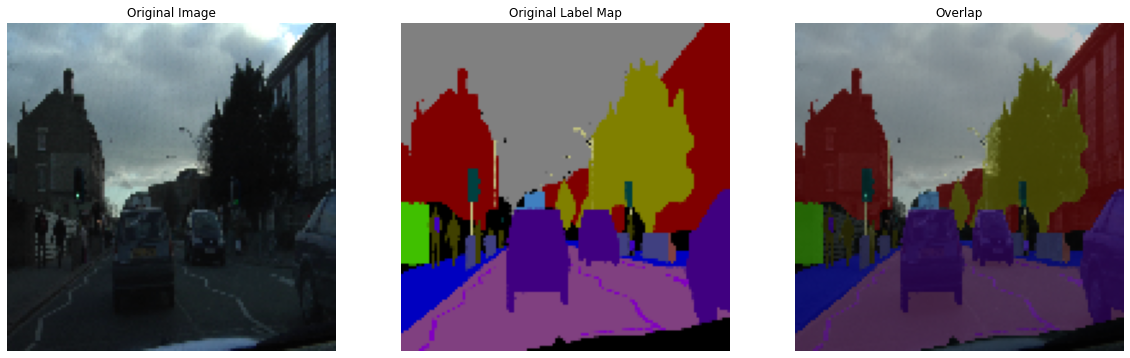

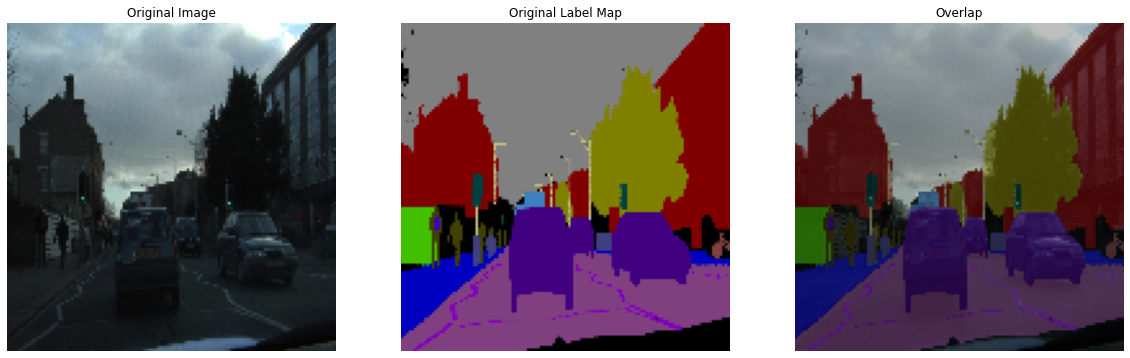

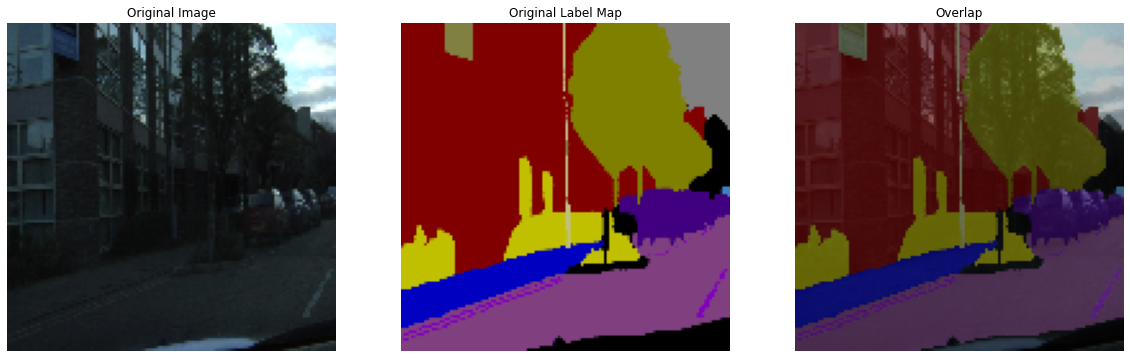

In [27]:
show_maps(train_ds)

## Modeling

### 2. Unet

#### Training

In [43]:
from models import Unet, DiceLoss

unet = Unet()
unet.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_114 (Conv2D)            (None, 128, 128, 64  1792        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 activation_95 (Activation)     (None, 128, 128, 64  0           ['conv2d_114[0][0]']             
                                )                                                           

In [45]:
from keras.callbacks import Callback

class ShowProgress(Callback):
    def on_epoch_end(self, epochs, logs=None):
        show_maps(data=valid_ds, model=self.model, n_images=1)

unet.compile(
    loss=DiceLoss(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

In [ ]:
history = unet.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=400,
    callbacks=[ShowProgress()]
)

#### Model prediction

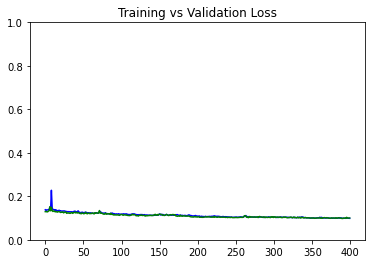

In [48]:
def plot_metrics(metric_name, title, ylim=5):
    """
    plots a given metric from the model history
    """
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

# Plot the training and validation loss
plot_metrics("loss", title="Training vs Validation Loss", ylim=1)

1/1 [==============================] - 0s 18ms/step


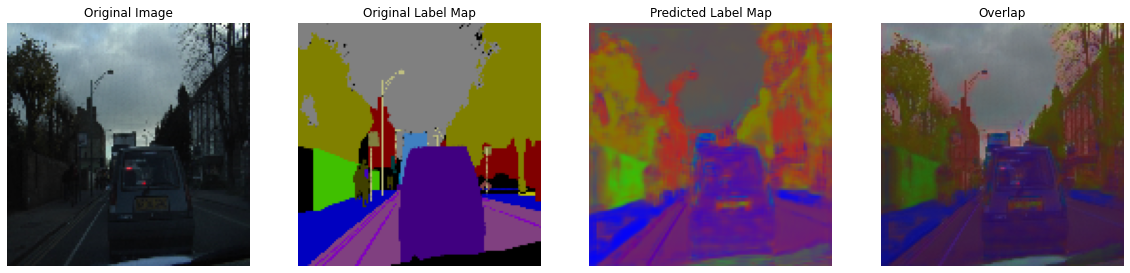

1/1 [==============================] - 0s 42ms/step


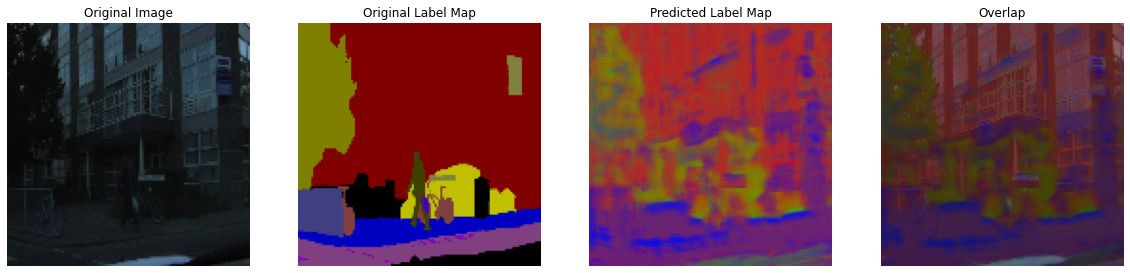

1/1 [==============================] - 0s 33ms/step


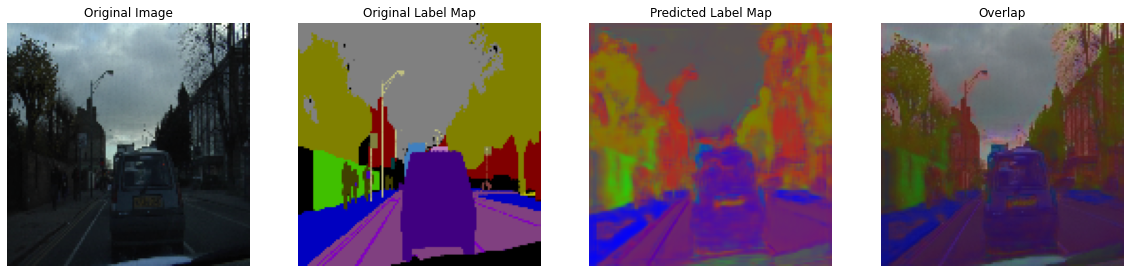

1/1 [==============================] - 0s 27ms/step


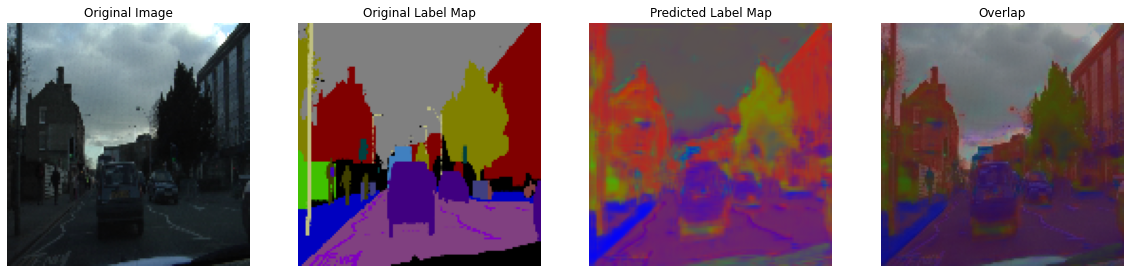

1/1 [==============================] - 0s 58ms/step


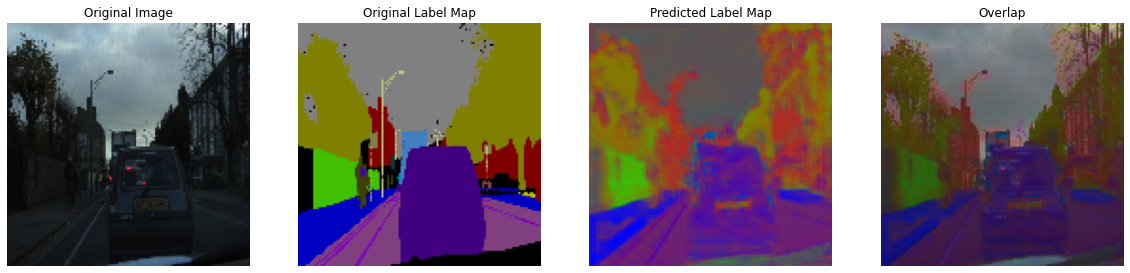

1/1 [==============================] - 0s 30ms/step


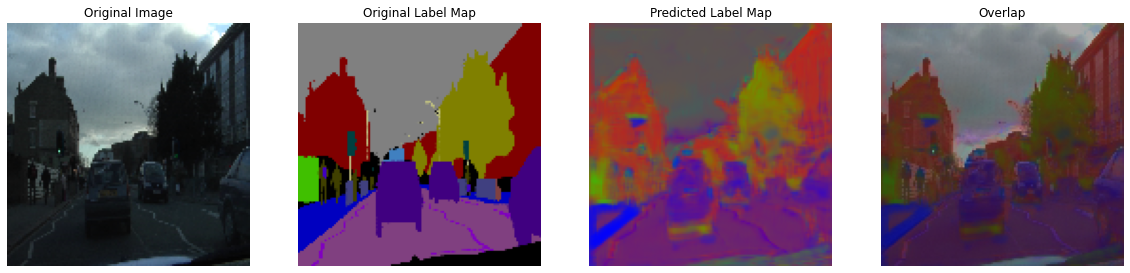

1/1 [==============================] - 0s 27ms/step


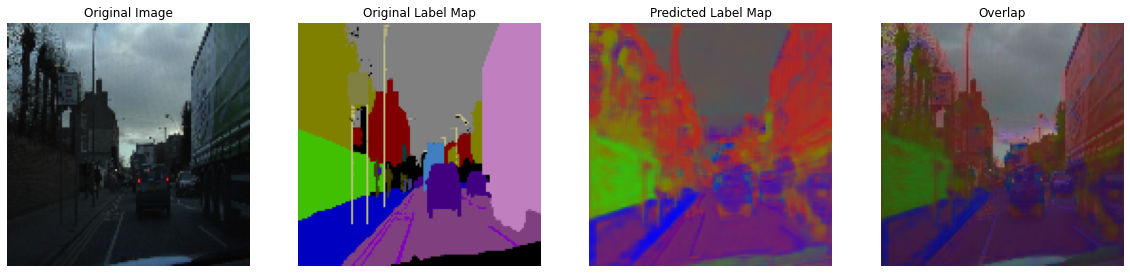

1/1 [==============================] - 0s 30ms/step


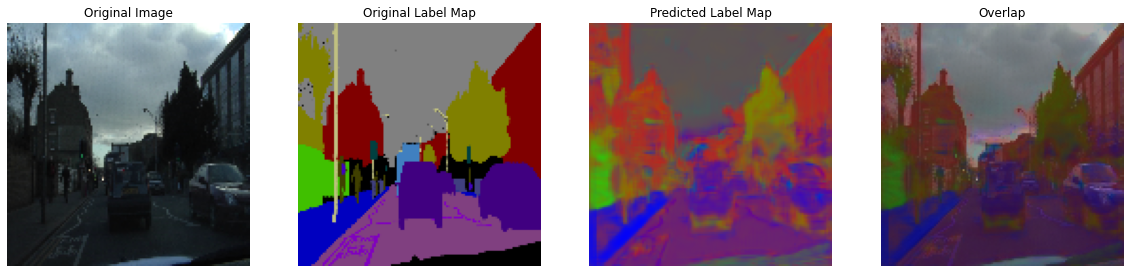

1/1 [==============================] - 0s 23ms/step


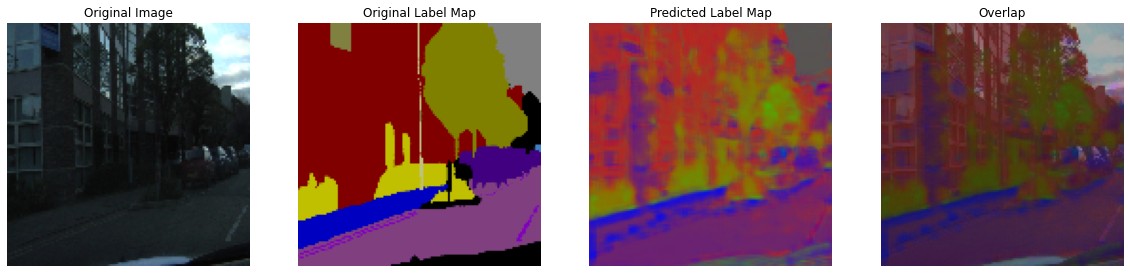

1/1 [==============================] - 0s 28ms/step


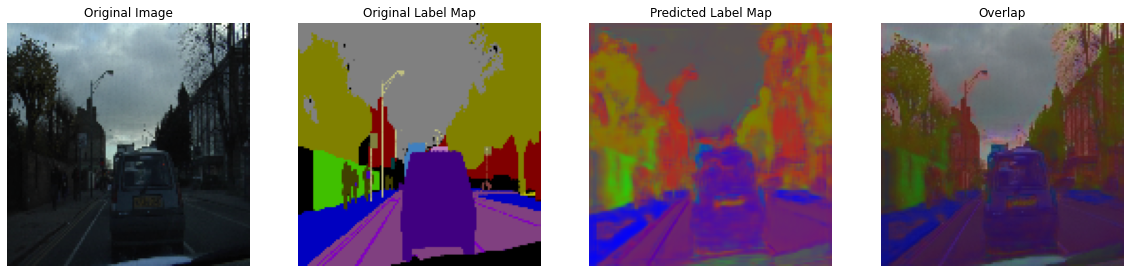

In [50]:
show_maps(train_ds, model=unet)